This jupyter notebook contains both **Roberta** and **DistilRoberta** models. Following are the few things to keep in mind

1. Roberta model is referred to as teacher model while as DistilRoberta model is referred to as student model
2. Both the models use the same dataloader but not the same class loader
3. Distillation of student model was done using the teacher model
4. The GPU cache memory has been cleared before the training of each model to ensure zero memory spillage
5. Model runtime has been recorded

In [1]:
import warnings
warnings.filterwarnings('ignore')
%pip install transformers==4.29.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import time
import psutil
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
# Checking for CUDA

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [4]:
raw_data = pd.read_csv("/kaggle/input/financial-sentiment-analysis/data.csv")
print("Columns: ", raw_data.columns)
print("Raw Dataset Shape: ", raw_data.shape)

Columns:  Index(['Sentence', 'Sentiment'], dtype='object')
Raw Dataset Shape:  (5842, 2)


In [5]:
raw_data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


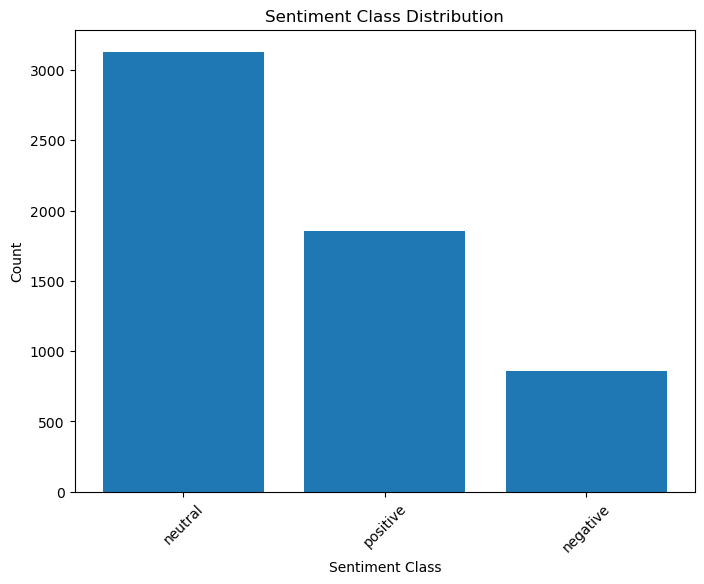

In [6]:
# PLotting the distribution of classes in the dataset
number_of_classes = raw_data["Sentiment"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(number_of_classes.index, number_of_classes.values)
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Sentiment Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Integer Enocoding of sentiment values
def integer_encoding(dataframe):
    
    sentiment_mapping = {
    'positive' : 0,
    'negative' : 1, 
    'neutral' : 2
    }
    
    dataframe['sentiment_encoded'] = dataframe['Sentiment'].map(sentiment_mapping)
    return dataframe

In [8]:
data = integer_encoding(raw_data)
data.head()

,Sentence,Sentiment,sentiment_encoded
0,The GeoSolutions technology will leverage Bene...,positive,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1
2,"For the last quarter of 2010 , Componenta 's n...",positive,0
3,According to the Finnish-Russian Chamber of Co...,neutral,2
4,The Swedish buyout firm has sold its remaining...,neutral,2


In [9]:
max_len = 256
train_batch_size = 8
val_batch_size = 4
learning_rate = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [10]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        super().__init__()
        self.tokenizer = tokenizer
        self.data = data
        self.sentences = data.Sentence
        self.sentiments = self.data.sentiment_encoded 
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentences = str(self.sentences[index])
        sentences = " ".join(sentences.split())
        
        inputs = self.tokenizer.encode_plus(
            sentences,
            None,
            add_special_tokens=True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        
        return {
            'ids' : torch.tensor(ids, dtype=torch.long),
            'mask' : torch.tensor(mask, dtype=torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
            'sentiments' : torch.tensor(self.sentiments[index], dtype=torch.int64)
        }

In [11]:
train_szie = 0.8
train_data = raw_data.sample(frac=train_szie, random_state=10)
test_data = raw_data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("Full Dataset: {}".format(raw_data.shape))
print("Train Dataset: {}".format(train_data.shape))
print("Test Dataset: {}".format(test_data.shape))

training_set = SentimentDataset(train_data, tokenizer, max_len)
testing_set = SentimentDataset(test_data, tokenizer, max_len)

Full Dataset: (5842, 3)
Train Dataset: (4674, 3)
Test Dataset: (1168, 3)


In [12]:
train_params = {'batch_size' : train_batch_size,
                'shuffle' : True,
                'num_workers' : 0
    
}

test_params = {'batch_size' : val_batch_size,
               'shuffle' : True,
               'num_workers' : 0
    
}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# RoBERTa model Implementation

In [13]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.layer = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 3)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_layer = self.layer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_layer[0]
        pooler = hidden_state[:,0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [14]:
# Clear the GPU memory, so that we can calculate the distillroberta performance
torch.cuda.empty_cache()

In [15]:
teacher_model = RobertaClass()
teacher_model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (layer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [16]:
# Loss function and opitmizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=teacher_model.parameters(), lr=learning_rate)

In [17]:
# Lists to store training and validation loss values of Roberta
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [18]:
# Function to calculate accuracy during training of the model
def calculate_accuracy(preds, sentiments):
    correct_classifications = (preds==sentiments).sum().item()
    return correct_classifications

In [19]:
# Training function on  80% of the dataset
def teacher_train(epoch):
    training_loss = 0
    correct_classifications = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    teacher_model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        sentiments = data['sentiments'].to(device, dtype=torch.long)
        
        outputs = teacher_model(ids, mask, token_type_ids)
        loss = loss_function(outputs, sentiments)
        training_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        correct_classifications += calculate_accuracy(big_idx, sentiments)
        
        nb_tr_steps += 1
        nb_tr_examples += sentiments.size(0)
        
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    epoch_loss = training_loss/nb_tr_steps
    train_losses.append(epoch_loss)
    epoch_accuracy = (correct_classifications*100)/nb_tr_examples
    train_accuracies.append(epoch_accuracy)
    
    print(f'The Total Accuracy for Epoch {epoch}: {epoch_accuracy:.2f}%')
    print(f"Training Loss Epoch {epoch+1}: {epoch_loss: .4f}")
    print(f"Training Accuracy Epoch {epoch+1}: {epoch_accuracy: .2f}%")

In [20]:
# Validation loop
def valid(model, testing_loader):
    model.eval()
    correct_classifications = 0
    training_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    with torch.no_grad():
        for batch in tqdm(testing_loader):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            sentiments = batch['sentiments'].to(device)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, sentiments)

            training_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            correct_classifications += calculate_accuracy(predicted_labels, sentiments)

            nb_tr_steps += 1
            nb_tr_examples += sentiments.size(0)

    epoch_loss = training_loss / nb_tr_steps
    # Append validation loss to the list
    valid_losses.append(epoch_loss)
    epoch_accuracy = (correct_classifications * 100) / nb_tr_examples
    valid_accuracies.append(epoch_accuracy)

    print(f"Validation Loss Epoch {epoch+1}: {epoch_loss: .4f}")
    print(f"Validation Accuracy Epoch {epoch+1}: {epoch_accuracy: .2f}%")

In [21]:
# Model Evaluation function
def evaluate(model, testing_loader):
    model.eval()
    y_true = []
    y_pred = []
    correct_classifications = 0; wrong_classifications = 0; training_loss = 0; nb_tr_steps = 0; nb_tr_examples = 0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            sentiments = data['sentiments'].to(device, dtype=torch.int64)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, sentiments)
            training_loss += loss.item()
            big_val, predicted = torch.max(outputs.data, dim=1)
            correct_classifications += calculate_accuracy(predicted, sentiments)
            
            nb_tr_steps += 1
            nb_tr_examples += sentiments.size(0)
            
            y_true.extend(sentiments.tolist())
            y_pred.extend(predicted.tolist())

            
        epoch_loss = training_loss / nb_tr_steps
        epoch_accu = (correct_classifications * 100) / nb_tr_examples
        
        return y_pred, y_true

In [22]:
# Calculate metrics
def compute_evaluation_metrics(true_labels, predicted_labels):
    class_names = ['negative', 'neutral', 'positive']
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision_weighted = precision_score(true_labels, predicted_labels, average='weighted')
    precision_macro = precision_score(true_labels, predicted_labels, average='macro')
    recall_weighted = recall_score(true_labels, predicted_labels, average='weighted')
    recall_macro = recall_score(true_labels, predicted_labels, average='macro')
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
    f1_macro = f1_score(true_labels, predicted_labels, average='macro')

    # Print metrics
    print("Metrics:")
    print("Accuracy:", format(accuracy, ".2f"))
    print("Precision (Weighted):", format(precision_weighted, ".2f"))
    print("Precision (Macro):", format(precision_macro, ".2f"))
    print("Recall (Weighted):", format(recall_weighted, ".2f"))
    print("Recall (Macro):", format(recall_macro, ".2f"))
    print("F1-score (Weighted):", format(f1_weighted, ".2f"))
    print("F1-score (Macro):", format(f1_macro, ".2f"))

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    labels = ['positive', 'negative', 'neutral']
    confusion_matrix_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Create metrics table
    metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision(weighted)', 'Precision(macro)', 'Recall(weighted)' , 'Recall(macro)', 'F1-Score (Weighted)', 'F1-Score (Macro)'],
                           'Score': [accuracy, precision_weighted,precision_macro,recall_weighted,recall_macro,f1_weighted, f1_macro]})

    print(metrics_df)
    print()

In [23]:
# Calculating the timestamp at the begining
roberta_start_time = time.time()

In [24]:
epochs = 10
for epoch in range(epochs):
    teacher_train(epoch)
    valid(teacher_model, testing_loader)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
585it [02:01,  4.80it/s]


The Total Accuracy for Epoch 0: 71.35%
Training Loss Epoch 1:  0.6466
Training Accuracy Epoch 1:  71.35%


100%|██████████| 292/292 [00:11<00:00, 26.07it/s]


Validation Loss Epoch 1:  0.4173
Validation Accuracy Epoch 1:  81.42%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 1: 82.93%
Training Loss Epoch 2:  0.3692
Training Accuracy Epoch 2:  82.93%


100%|██████████| 292/292 [00:11<00:00, 26.48it/s]


Validation Loss Epoch 2:  0.3614
Validation Accuracy Epoch 2:  84.42%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 2: 85.75%
Training Loss Epoch 3:  0.2863
Training Accuracy Epoch 3:  85.75%


100%|██████████| 292/292 [00:10<00:00, 26.59it/s]


Validation Loss Epoch 3:  0.4194
Validation Accuracy Epoch 3:  79.88%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 3: 87.25%
Training Loss Epoch 4:  0.2431
Training Accuracy Epoch 4:  87.25%


100%|██████████| 292/292 [00:11<00:00, 26.49it/s]


Validation Loss Epoch 4:  0.3989
Validation Accuracy Epoch 4:  81.42%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 4: 88.79%
Training Loss Epoch 5:  0.2122
Training Accuracy Epoch 5:  88.79%


100%|██████████| 292/292 [00:10<00:00, 26.59it/s]


Validation Loss Epoch 5:  0.4848
Validation Accuracy Epoch 5:  80.14%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 5: 89.24%
Training Loss Epoch 6:  0.1946
Training Accuracy Epoch 6:  89.24%


100%|██████████| 292/292 [00:11<00:00, 26.50it/s]


Validation Loss Epoch 6:  0.4949
Validation Accuracy Epoch 6:  79.45%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 6: 89.60%
Training Loss Epoch 7:  0.1893
Training Accuracy Epoch 7:  89.60%


100%|██████████| 292/292 [00:11<00:00, 26.46it/s]


Validation Loss Epoch 7:  0.4812
Validation Accuracy Epoch 7:  78.94%


585it [02:00,  4.87it/s]


The Total Accuracy for Epoch 7: 89.90%
Training Loss Epoch 8:  0.1785
Training Accuracy Epoch 8:  89.90%


100%|██████████| 292/292 [00:11<00:00, 26.43it/s]


Validation Loss Epoch 8:  0.4877
Validation Accuracy Epoch 8:  80.05%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 8: 90.24%
Training Loss Epoch 9:  0.1620
Training Accuracy Epoch 9:  90.24%


100%|██████████| 292/292 [00:11<00:00, 26.53it/s]


Validation Loss Epoch 9:  0.4770
Validation Accuracy Epoch 9:  83.99%


585it [02:00,  4.86it/s]


The Total Accuracy for Epoch 9: 90.67%
Training Loss Epoch 10:  0.1526
Training Accuracy Epoch 10:  90.67%


100%|██████████| 292/292 [00:10<00:00, 26.58it/s]

Validation Loss Epoch 10:  0.5691
Validation Accuracy Epoch 10:  81.93%


In [25]:
# Calulcate end time and total runtime of the model in seconds
roberta_end_time = time.time()
roberta_running_time = roberta_end_time - roberta_start_time
print(f"Running Time of RoBERTa model: {roberta_running_time} seconds or {roberta_running_time / 60} minutes or {roberta_running_time / 3600} hours")

Running Time of RoBERTa model: 1315.1338317394257 seconds or 21.918897195657095 minutes or 0.3653149532609516 hours


In [26]:
process = psutil.Process()
roberta_memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"Memory Usage of RoBERTa model: {roberta_memory_usage} MB")

Memory Usage of RoBERTa model: 3309.05078125 MB


292it [00:10, 26.64it/s]


Metrics:
Accuracy: 0.82
Precision (Weighted): 0.81
Precision (Macro): 0.77
Recall (Weighted): 0.82
Recall (Macro): 0.73
F1-score (Weighted): 0.81
F1-score (Macro): 0.74


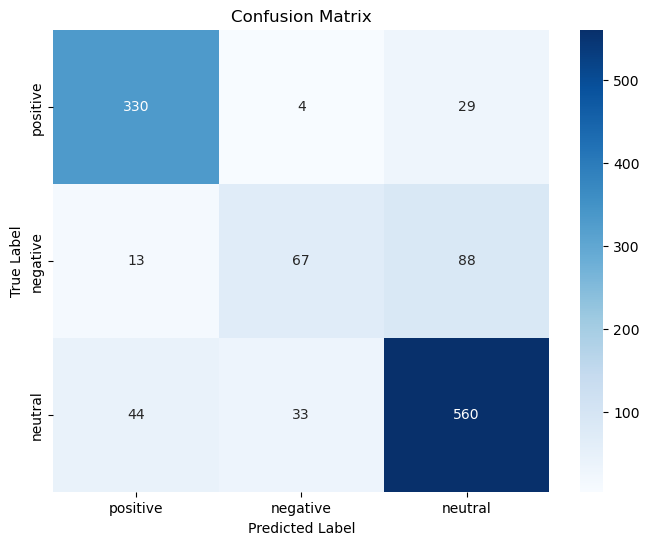

                Metric     Score
0             Accuracy  0.819349
1  Precision(weighted)  0.808800
2     Precision(macro)  0.774708
3     Recall(weighted)  0.819349
4        Recall(macro)  0.729007
5  F1-Score (Weighted)  0.809210
6     F1-Score (Macro)  0.741669



In [27]:
#Evaluating teacher model on test data
predicted_labels, true_labels = evaluate(teacher_model, testing_loader)
compute_evaluation_metrics(true_labels, predicted_labels)

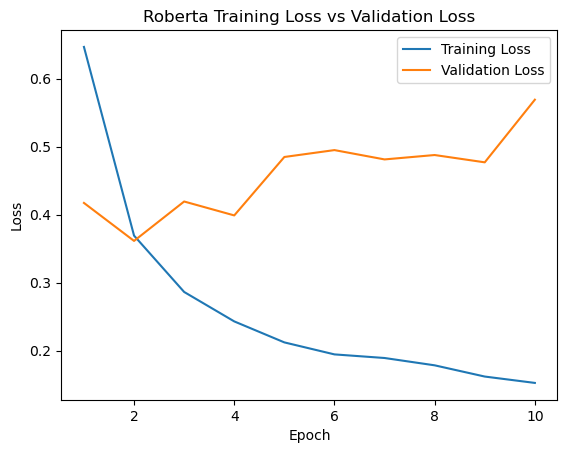

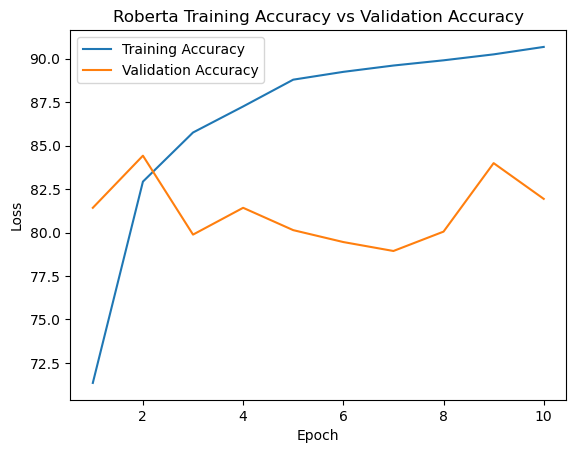

In [28]:
 # Plot training and validation loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Roberta Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Roberta Training Accuracy vs Validation Accuracy')
plt.legend()
plt.show()

# **Class Based Evaluation Metrics (RoBERTa)**

In [29]:
class_names = [0, 1, 2]
class_labels = {0: 'positive', 1: 'negative', 2: 'neutral'}

# Define lists to store the metric values for each class
accuracy_list = []
precision_weighted_list = []
precision_macro_list = []
recall_weighted_list = []
recall_macro_list = []
f1_weighted_list = []
f1_macro_list = []

for class_name in class_names:
    # Filter labels for the current class
    class_label = class_labels[class_name]
    class_indices = [i for i in range(len(true_labels)) if true_labels[i] == class_name]
    true_labels_class = [true_labels[i] for i in class_indices]
    predicted_labels_class = [predicted_labels[i] for i in class_indices]

    # Calculate metrics for the current class
    accuracy_class = accuracy_score(true_labels_class, predicted_labels_class)
    precision_weighted_class = precision_score(true_labels_class, predicted_labels_class, average='weighted')
    precision_macro_class = precision_score(true_labels_class, predicted_labels_class, average='macro')
    recall_weighted_class = recall_score(true_labels_class, predicted_labels_class, average='weighted')
    recall_macro_class = recall_score(true_labels_class, predicted_labels_class, average='macro')
    f1_weighted_class = f1_score(true_labels_class, predicted_labels_class, average='weighted')
    f1_macro_class = f1_score(true_labels_class, predicted_labels_class, average='macro')
    
    # Append the metric values to the corresponding lists
    accuracy_list.append(accuracy_class)
    precision_weighted_list.append(precision_weighted_class)
    precision_macro_list.append(precision_macro_class)
    recall_weighted_list.append(recall_weighted_class)
    recall_macro_list.append(recall_macro_class)
    f1_weighted_list.append(f1_weighted_class)
    f1_macro_list.append(f1_macro_class)

    # Print metrics for the current class
    print(f"Metrics for {class_label.capitalize()} Class:")
    print("Accuracy:", format(accuracy_class, ".2f"))
    print("Precision (Weighted):", format(precision_weighted_class, ".2f"))
    print("Precision (Macro):", format(precision_macro_class, ".2f"))
    print("Recall (Weighted):", format(recall_weighted_class, ".2f"))
    print("Recall (Macro):", format(recall_macro_class, ".2f"))
    print("F1-score (Weighted):", format(f1_weighted_class, ".2f"))
    print("F1-score (Macro):", format(f1_macro_class, ".2f"))
    print()

Metrics for Positive Class:
Accuracy: 0.91
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.91
Recall (Macro): 0.30
F1-score (Weighted): 0.95
F1-score (Macro): 0.32

Metrics for Negative Class:
Accuracy: 0.40
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.40
Recall (Macro): 0.13
F1-score (Weighted): 0.57
F1-score (Macro): 0.19

Metrics for Neutral Class:
Accuracy: 0.88
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.88
Recall (Macro): 0.29
F1-score (Weighted): 0.94
F1-score (Macro): 0.31



#  Plots for class based evaluation metrics (RoBERTa)

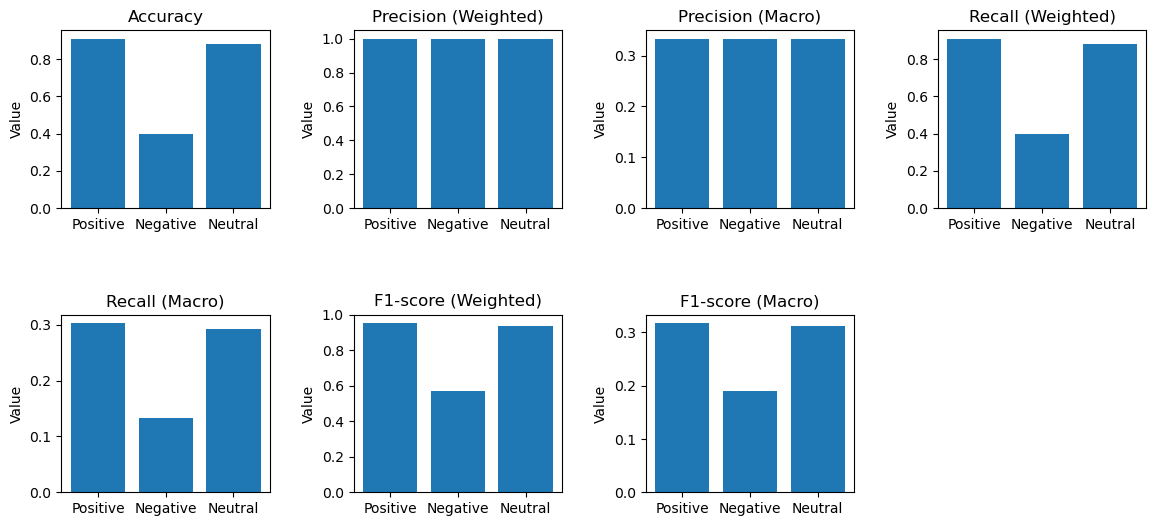

In [30]:
# Define the x-axis ticks for the bar plot
x_ticks = [class_labels[class_name].capitalize() for class_name in class_names]

# Create the bar plot
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(2, 4, 1)
plt.bar(x_ticks, accuracy_list)
plt.title('Accuracy')
plt.ylabel('Value')

# Precision (Weighted)
plt.subplot(2, 4, 2)
plt.bar(x_ticks, precision_weighted_list)
plt.title('Precision (Weighted)')
plt.ylabel('Value')

# Precision (Macro)
plt.subplot(2, 4, 3)
plt.bar(x_ticks, precision_macro_list)
plt.title('Precision (Macro)')
plt.ylabel('Value')

# Recall (Weighted)
plt.subplot(2, 4, 4)
plt.bar(x_ticks, recall_weighted_list)
plt.title('Recall (Weighted)')
plt.ylabel('Value')

# Recall (Weighted)
plt.subplot(2, 4, 5)
plt.bar(x_ticks, recall_macro_list)
plt.title('Recall (Macro)')
plt.ylabel('Value')

# f1-score (Weighted)
plt.subplot(2, 4, 6)
plt.bar(x_ticks, f1_weighted_list)
plt.title('F1-score (Weighted)')
plt.ylabel('Value')

# f1-score (Macro)
plt.subplot(2, 4, 7)
plt.bar(x_ticks, f1_macro_list)
plt.title('F1-score (Macro)')
plt.ylabel('Value')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

In [31]:
# Clear the GPU memory once again before loading student model to the device
torch.cuda.empty_cache()

# DistilRoberta Model Implementation

In [32]:
#DistilRoberta implemenatation
class DistilRobertaClassifier(torch.nn.Module):
    def __init__(self):
        super(DistilRobertaClassifier, self).__init__()
        self.layer = RobertaModel.from_pretrained("roberta-base", num_hidden_layers=6)  #Set the number of hidden layers to 6
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 3)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_layer = self.layer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_layer[0]
        pooler = hidden_state[:,0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [33]:
#student model
student_model = DistilRobertaClassifier()
student_model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.encoder.layer.8.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.self.value.bias', 'roberta.encoder.layer.9.output.LayerNorm.weight', 'roberta.encoder.layer.6.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.key.bias', 'roberta.encoder.layer.11.intermediate.dense.bias', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'lm_head.layer_norm.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.weight', 'roberta.encoder.layer.8.output.dense.weight', 'roberta.encoder.layer.8.attention.self.value.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.11.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.bias', 'robert

DistilRobertaClassifier(
  (layer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [34]:
#Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=student_model.parameters(), lr=learning_rate)

In [35]:
#Distillation parameter
temperature = 3.0

In [36]:
# Distillation loss
def distillation_loss(student_logits, teacher_logits):
    student_probs = torch.nn.functional.softmax(student_logits / temperature, dim=1)
    teacher_probs = torch.nn.functional.softmax(teacher_logits / temperature, dim=1)
    loss = torch.nn.KLDivLoss()(torch.log(student_probs), teacher_probs)
    return loss

In [37]:
# Reset Lists to store training and validation loss values of DistilRoberta
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [38]:
#Train function for DistillRoberta
def student_train(epoch):
    student_model.train()
    training_loss = 0
    correct_classifications = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    
    for _, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        sentiments = data['sentiments'].to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        
        # Forward pass through teacher model
        with torch.no_grad():
            teacher_logits = teacher_model(ids, mask, token_type_ids)

        # Forward pass through student model
        student_logits = student_model(ids, mask, token_type_ids)

        # Calculate distillation loss
        distillation_loss_value = distillation_loss(student_logits, teacher_logits)

        # Calculate total loss
        loss = loss_function(student_logits, sentiments) + distillation_loss_value
        training_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(student_logits, 1)
        correct_classifications += (predicted_labels == sentiments).sum().item()

        nb_tr_steps += 1
        nb_tr_examples += sentiments.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = training_loss / nb_tr_steps
    train_losses.append(epoch_loss)
    epoch_accuracy = (correct_classifications * 100) / nb_tr_examples
    train_accuracies.append(epoch_accuracy)
    
    print(f'The Total Accuracy for Epoch {epoch}: {epoch_accuracy:.2f}%')
    print(f"Training Loss Epoch {epoch+1}: {epoch_loss: .4f}")
    print(f"Training Accuracy Epoch {epoch+1}: {epoch_accuracy: .2f}%")

In [39]:
# Calculating the timestamp at the begining
distillRoberta_start_time = time.time()

In [40]:
#Training Loop for DistilRoberta
for epoch in range(epochs):
    student_train(epoch)
    valid(student_model, testing_loader)

585it [01:37,  5.99it/s]


The Total Accuracy for Epoch 0: 63.50%
Training Loss Epoch 1:  0.9382
Training Accuracy Epoch 1:  63.50%


100%|██████████| 292/292 [00:06<00:00, 48.30it/s]


Validation Loss Epoch 1:  0.4648
Validation Accuracy Epoch 1:  79.97%


585it [01:37,  5.99it/s]


The Total Accuracy for Epoch 1: 80.59%
Training Loss Epoch 2:  0.5122
Training Accuracy Epoch 2:  80.59%


100%|██████████| 292/292 [00:05<00:00, 48.94it/s]


Validation Loss Epoch 2:  0.4232
Validation Accuracy Epoch 2:  80.48%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 2: 84.27%
Training Loss Epoch 3:  0.3761
Training Accuracy Epoch 3:  84.27%


100%|██████████| 292/292 [00:06<00:00, 48.58it/s]


Validation Loss Epoch 3:  0.4221
Validation Accuracy Epoch 3:  81.16%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 3: 85.94%
Training Loss Epoch 4:  0.2979
Training Accuracy Epoch 4:  85.94%


100%|██████████| 292/292 [00:06<00:00, 48.56it/s]


Validation Loss Epoch 4:  0.4999
Validation Accuracy Epoch 4:  77.74%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 4: 88.13%
Training Loss Epoch 5:  0.2403
Training Accuracy Epoch 5:  88.13%


100%|██████████| 292/292 [00:05<00:00, 48.76it/s]


Validation Loss Epoch 5:  0.5902
Validation Accuracy Epoch 5:  78.17%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 5: 88.19%
Training Loss Epoch 6:  0.2218
Training Accuracy Epoch 6:  88.19%


100%|██████████| 292/292 [00:06<00:00, 48.54it/s]


Validation Loss Epoch 6:  0.6698
Validation Accuracy Epoch 6:  77.91%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 6: 89.35%
Training Loss Epoch 7:  0.1954
Training Accuracy Epoch 7:  89.35%


100%|██████████| 292/292 [00:06<00:00, 48.54it/s]


Validation Loss Epoch 7:  0.5873
Validation Accuracy Epoch 7:  79.11%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 7: 89.43%
Training Loss Epoch 8:  0.1866
Training Accuracy Epoch 8:  89.43%


100%|██████████| 292/292 [00:06<00:00, 47.71it/s]


Validation Loss Epoch 8:  0.6246
Validation Accuracy Epoch 8:  82.19%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 8: 89.84%
Training Loss Epoch 9:  0.1754
Training Accuracy Epoch 9:  89.84%


100%|██████████| 292/292 [00:06<00:00, 48.57it/s]


Validation Loss Epoch 9:  0.6700
Validation Accuracy Epoch 9:  80.57%


585it [01:37,  5.98it/s]


The Total Accuracy for Epoch 9: 90.20%
Training Loss Epoch 10:  0.1639
Training Accuracy Epoch 10:  90.20%


100%|██████████| 292/292 [00:05<00:00, 48.82it/s]

Validation Loss Epoch 10:  0.7076
Validation Accuracy Epoch 10:  77.48%


In [41]:
# Calulcate end time and total runtime of the model in seconds
distillRoberta_end_time = time.time()
distillRoberta_running_time = distillRoberta_end_time - distillRoberta_start_time
print(f"Running Time of DistillRoBERTa model: {distillRoberta_running_time} seconds or {distillRoberta_running_time / 60} minutes or {distillRoberta_running_time / 3600} hours")

Running Time of DistillRoBERTa model: 1037.9932277202606 seconds or 17.29988712867101 minutes or 0.28833145214451683 hours


In [42]:
# Calculating memory usage
process = psutil.Process()
distillRoberta_memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"Memory Usage of DistillRoBERTa model: {distillRoberta_memory_usage} MB")

Memory Usage of DistillRoBERTa model: 3420.30859375 MB


292it [00:06, 48.59it/s]


Metrics:
Accuracy: 0.77
Precision (Weighted): 0.79
Precision (Macro): 0.72
Recall (Weighted): 0.77
Recall (Macro): 0.75
F1-score (Weighted): 0.78
F1-score (Macro): 0.73


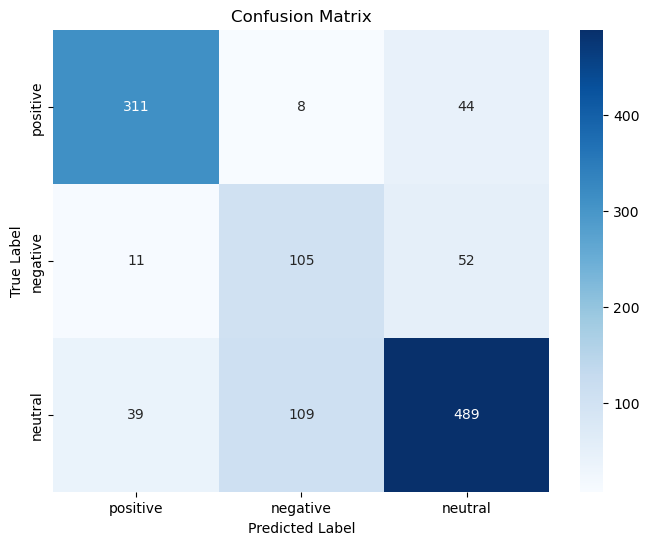

                Metric     Score
0             Accuracy  0.774829
1  Precision(weighted)  0.791652
2     Precision(macro)  0.723455
3     Recall(weighted)  0.774829
4        Recall(macro)  0.749803
5  F1-Score (Weighted)  0.780933
6     F1-Score (Macro)  0.732635



In [43]:
#Evaluating student model on test data
student_predicted_labels, student_true_labels = evaluate(student_model, testing_loader)
compute_evaluation_metrics(student_true_labels, student_predicted_labels)

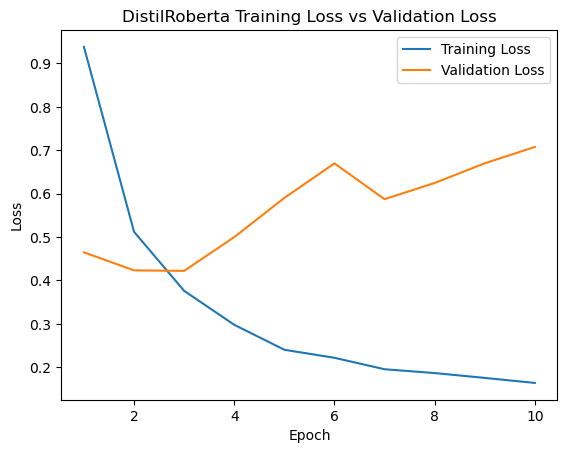

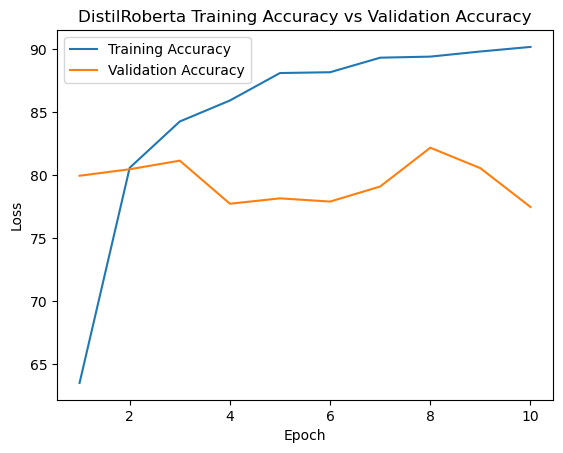

In [44]:
 # Plot training and validation loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DistilRoberta Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DistilRoberta Training Accuracy vs Validation Accuracy')
plt.legend()
plt.show()

# Class Based Evaluation Metrics (DistilRoberta)

In [45]:
# Define lists to store the metric values for each class
student_accuracy_list = []
student_precision_weighted_list = []
student_precision_macro_list = []
student_recall_weighted_list = []
student_recall_macro_list = []
student_f1_weighted_list = []
student_f1_macro_list = []

for class_name in class_names:
    # Filter labels for the current class
    class_label = class_labels[class_name]
    class_indices = [i for i in range(len(student_true_labels)) if student_true_labels[i] == class_name]
    true_labels_class = [student_true_labels[i] for i in class_indices]
    predicted_labels_class = [student_predicted_labels[i] for i in class_indices]

    # Calculate metrics for the current class
    accuracy_class = accuracy_score(true_labels_class, predicted_labels_class)
    precision_weighted_class = precision_score(true_labels_class, predicted_labels_class, average='weighted')
    precision_macro_class = precision_score(true_labels_class, predicted_labels_class, average='macro')
    recall_weighted_class = recall_score(true_labels_class, predicted_labels_class, average='weighted')
    recall_macro_class = recall_score(true_labels_class, predicted_labels_class, average='macro')
    f1_weighted_class = f1_score(true_labels_class, predicted_labels_class, average='weighted')
    f1_macro_class = f1_score(true_labels_class, predicted_labels_class, average='macro')
    
    # Append the metric values to the corresponding lists
    student_accuracy_list.append(accuracy_class)
    student_precision_weighted_list.append(precision_weighted_class)
    student_precision_macro_list.append(precision_macro_class)
    student_recall_weighted_list.append(recall_weighted_class)
    student_recall_macro_list.append(recall_macro_class)
    student_f1_weighted_list.append(f1_weighted_class)
    student_f1_macro_list.append(f1_macro_class)

    # Print metrics for the current class
    print(f"Metrics for {class_label.capitalize()} Class:")
    print("Accuracy:", format(accuracy_class, ".2f"))
    print("Precision (Weighted):", format(precision_weighted_class, ".2f"))
    print("Precision (Macro):", format(precision_macro_class, ".2f"))
    print("Recall (Weighted):", format(recall_weighted_class, ".2f"))
    print("Recall (Macro):", format(recall_macro_class, ".2f"))
    print("F1-score (Weighted):", format(f1_weighted_class, ".2f"))
    print("F1-score (Macro):", format(f1_macro_class, ".2f"))
    print()

Metrics for Positive Class:
Accuracy: 0.86
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.86
Recall (Macro): 0.29
F1-score (Weighted): 0.92
F1-score (Macro): 0.31

Metrics for Negative Class:
Accuracy: 0.62
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.62
Recall (Macro): 0.21
F1-score (Weighted): 0.77
F1-score (Macro): 0.26

Metrics for Neutral Class:
Accuracy: 0.77
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.77
Recall (Macro): 0.26
F1-score (Weighted): 0.87
F1-score (Macro): 0.29



#  Plots for class based evaluation metrics (DistilRoberta)

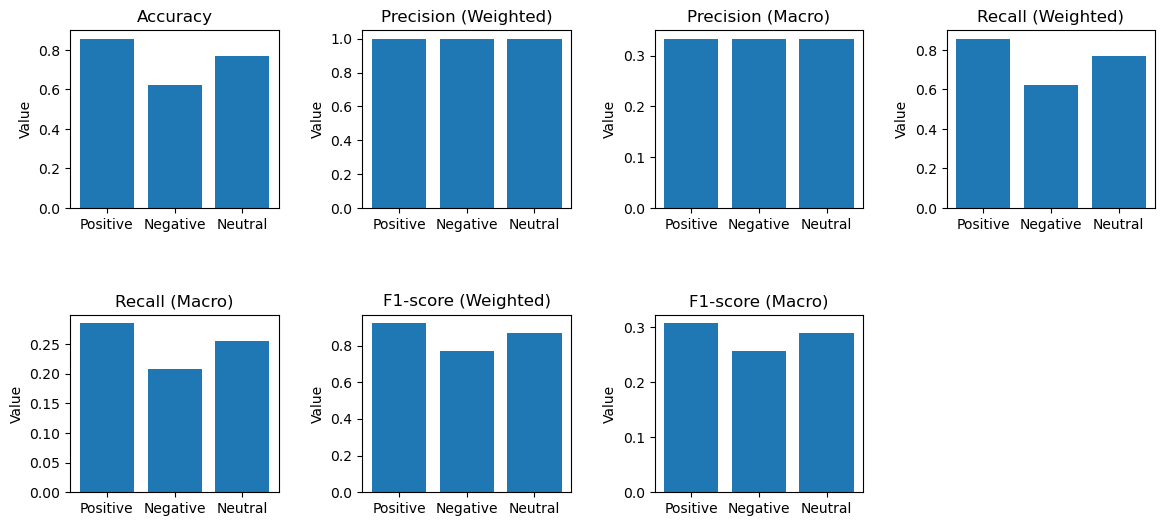

In [46]:
# Define the x-axis ticks for the bar plot
x_ticks = [class_labels[class_name].capitalize() for class_name in class_names]

# Create the bar plot
plt.figure(figsize=(14, 6))

#Accuracy
plt.subplot(2, 4, 1)
plt.bar(x_ticks, student_accuracy_list)
plt.title('Accuracy')
plt.ylabel('Value')

# Precision (Weighted)
plt.subplot(2, 4, 2)
plt.bar(x_ticks, student_precision_weighted_list)
plt.title('Precision (Weighted)')
plt.ylabel('Value')

# Precision (Macro)
plt.subplot(2, 4, 3)
plt.bar(x_ticks, student_precision_macro_list)
plt.title('Precision (Macro)')
plt.ylabel('Value')

# Recall (Weighted)
plt.subplot(2, 4, 4)
plt.bar(x_ticks, student_recall_weighted_list)
plt.title('Recall (Weighted)')
plt.ylabel('Value')

# Recall (Weighted)
plt.subplot(2, 4, 5)
plt.bar(x_ticks, student_recall_macro_list)
plt.title('Recall (Macro)')
plt.ylabel('Value')

# f1-score (Weighted)
plt.subplot(2, 4, 6)
plt.bar(x_ticks, student_f1_weighted_list)
plt.title('F1-score (Weighted)')
plt.ylabel('Value')

# f1-score (Macro)
plt.subplot(2, 4, 7)
plt.bar(x_ticks, student_f1_macro_list)
plt.title('F1-score (Macro)')
plt.ylabel('Value')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

**Roberta's Performance Metrics**
* Runtime: 21.91 minutes
* Memory usage: 3309.05 MB
* Train Accuracy: 90.67%
* Test Accuracy: 81.93%

**DistilRoberta's Performance Metrics**
* Runtime: 17.29 minutes
* Memory usage: 3420.30 MB
* Train Accuracy: 90.20%
* Test Accuracy: 77.48%

As we can clearly see that DistilRoberta is faster than Roberta by retaining most of the latter's accuracy